# Exploratory Analisys

## Context

This notebook is a continuation of **eda-linear.ipynb**, so it is highly recommended to follow the notebooks in order. Here, we resume the analysis of linear relationships. After identifying and removing the seasonal pattern, we now turn to investigating the autoregressive structure of the data. To this end, we employ models from the ARIMA family to detect and remove any remaining autoregressive components.

**Data Source**
The data used in this notebook was extracted from the notebook *eda-linear.ipynb*

- **Data:** 17/08/2025
- **Localização:** ../data/wrangle

## Set up

### Libraries

In [1]:
## Base
import os
import numpy as np
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Statistic
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[0].as_posix())

from src.ts_utils import *

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

## Data

In [4]:
weather_df = pd.read_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_linear_resids.parquet'))
display(weather_df.tail())
weather_df.info()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal,log_tavg,box_tavg,y_hat,resid
1815,2020-08-05,293.1,0.0,0.0,3.1,1018.8,10.5,Southwest,-5.680514,-1.514255e+10,298.109362,-5.009362
1816,2020-08-06,295.6,0.0,0.0,2.4,1018.9,8.4,East,-5.689007,-1.571738e+10,298.052259,-2.452259
1817,2020-08-07,296.5,0.0,0.0,2.4,1019.8,12.2,Southeast,-5.692047,-1.592839e+10,297.991868,-1.491868
1818,2020-08-08,298.4,0.0,0.0,4.3,1018.7,11.3,South,-5.698435,-1.638104e+10,297.928233,0.471767
1819,2020-08-09,300.3,0.0,0.0,5.1,1015.8,10.0,South,-5.704782,-1.684356e+10,297.861396,2.438604


<class 'pandas.core.frame.DataFrame'>
Index: 1820 entries, 0 to 1819
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       1820 non-null   datetime64[ns]
 1   tavg       1820 non-null   float64       
 2   prcp       1820 non-null   float64       
 3   snow       1820 non-null   float64       
 4   wspd       1820 non-null   float64       
 5   pres       1820 non-null   float64       
 6   tamp       1820 non-null   float64       
 7   wcardinal  1806 non-null   category      
 8   log_tavg   1820 non-null   float64       
 9   box_tavg   1820 non-null   float64       
 10  y_hat      1820 non-null   float64       
 11  resid      1820 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(10)
memory usage: 172.8 KB


# Autoregressive

In [5]:
weather_df = weather_df.set_index('time').asfreq('D')

## Stationarity
We begin the autoregressive analysis by examining the stationarity of the residuals to determine whether any additional transformation is necessary. To do so, we perform the Augmented Dickey–Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests, using a 5% significance level to assess stationarity.

In [6]:
stationary_tests(weather_df['resid'])

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 1.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


/home/pedro.moura/Pessoal/WeatherForecast/src/ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


The KPSS test indicates that our data is not yet stationary. Therefore, before proceeding, we apply the most common stationarity transformation, differencing: $y^*_{t} = y_{t} - y_{t-1}$.

In [7]:
resid_diff = weather_df['resid'].diff()
resid_diff.dropna(inplace=True)
stationary_tests(resid_diff)

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


/home/pedro.moura/Pessoal/WeatherForecast/src/ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


## ARIMA Family Parameters

ARIMA-family models consist of three primary parameters: $p$, $d$, and $q$. For seasonal ARIMA models, additional parameters $P$, $D$, $Q$, and $m$ are included. Since we applied differencing to achieve stationarity, we set $d = 1$. Additionally, having removed the seasonal component, we do not consider the seasonal parameters $P$, $D$, $Q$, or $m$. This leaves only $p$ and $q$ to be determined. To identify them, we analyze the ACF and PACF plots to examine correlation patterns and guide the selection of the optimal model.

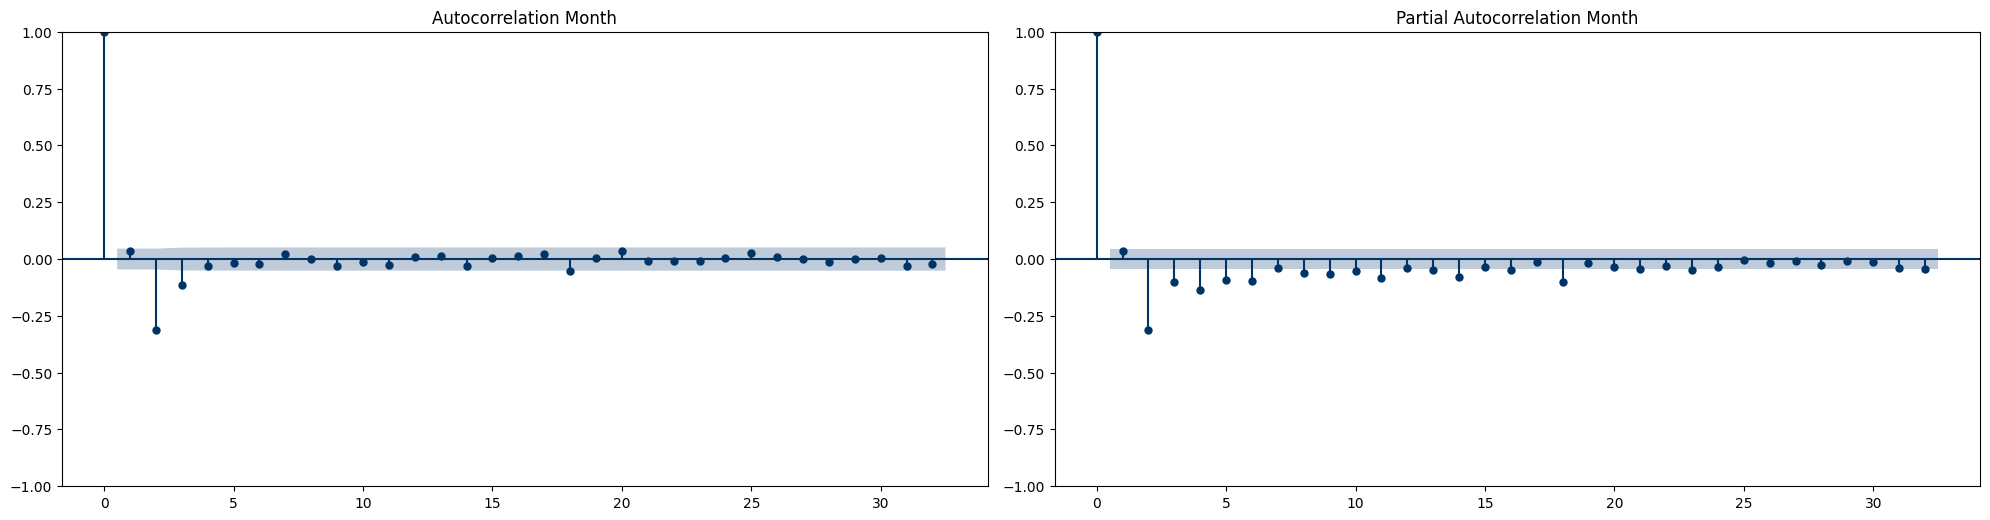

In [8]:
plot_acf_pacf(resid_diff)

Based on the ACF and PACF plots, the potential parameters are $q = 2$ or $3$ and $p = 2$. Although some other lags exceed the significance threshold in the PACF plot, their magnitude is considerably smaller than that of the second lag.

* $(p,d,q) = (2,1,2)$
* $(p,d,q) = (2,1,3)$
* $(p,d,q) = (3,1,2)$
* $(p,d,q) = (3,1,3)$
* $(p,d,q) = (4,1,2)$
* $(p,d,q) = (4,1,3)$

### ARIMA(2,1,2)

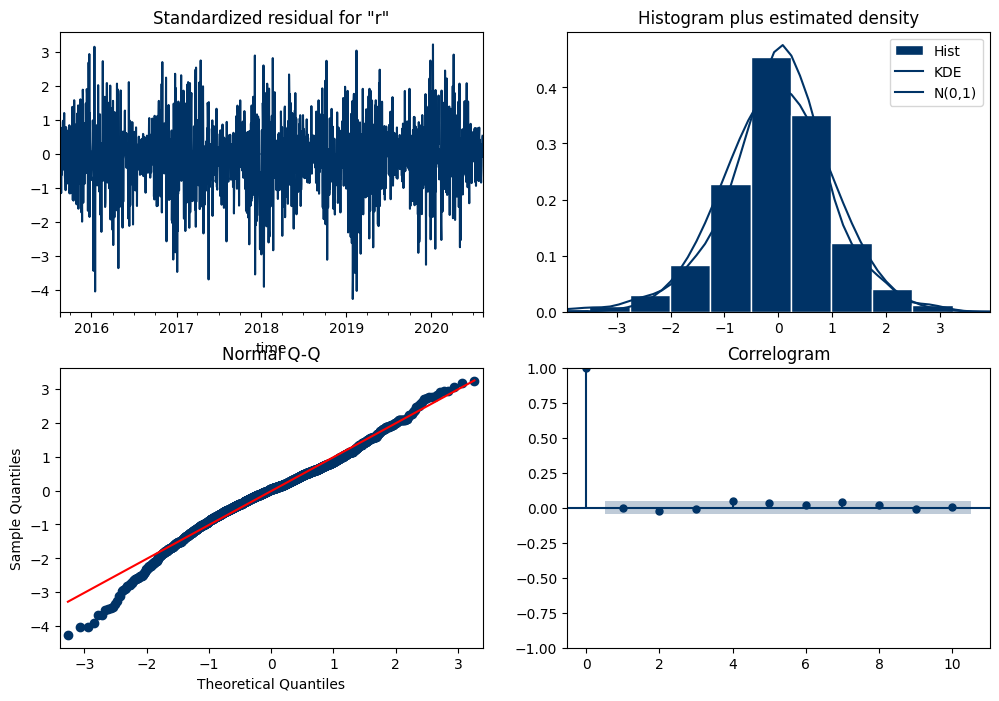

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  resid   No. Observations:                 1820
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -4692.410
Date:                Sun, 17 Aug 2025   AIC                           9394.821
Time:                        17:59:02   BIC                           9422.351
Sample:                    08-17-2015   HQIC                          9404.978
                         - 08-09-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3748      0.066      5.667      0.000       0.245       0.504
ar.L2          0.1398      0.054      2.584      0.010       0.034       0.246
ma.L1         -0.4627      0.061     -7.569      0.000      -0.583      -0.343
ma.L2         -0.5310      0.061     -8.676      0.000      -0.651      -0.411
sigma2        10.1713      0.269     37.813      0.000       9.644      10.699
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               161.22
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.36
Prob(H) (two-sided):                  0.85   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
model_212 = SARIMAX(endog=weather_df['resid'], order=(2,1,2))
res_212 = model_212.fit()

res_212.plot_diagnostics(figsize=(12,8))
plt.show()
res_212.summary()

First, we observe that the model successfully removes all autocorrelation in the residuals, which is an excellent result. All model components are statistically significant. Increasing the number of parameters is not recommended, as this would raise model complexity, increase training time, and could reintroduce autocorrelation in the residuals.  Based on this assessment, rather than following the previously defined parameter grid, this model is selected. We now evaluate its forecasting performance on the validation set and examine the resulting metrics.

# Result
With the selected model, we now evaluate its forecasting performance on the validation set and examine the resulting performance metrics.

In [10]:
max_steps = 50
min_steps = 10
forecast_dict = {}

for i, step in enumerate(range(max_steps, min_steps - 1, -1)):
    if step == max_steps:
        # Train the model
        train = weather_df['resid'][:-step].copy()
        model = SARIMAX(endog=train, order=(2,1,2))
        res = model.fit()
    
    # Forecast min_steps ahead
    forecast = res.forecast(min_steps)

    # Saving error
    test = weather_df['resid'][-step:].copy()
    forecast_dict[i] = ((test - forecast)**2).dropna().tolist()

    # Update the model
    res = res.append(test[:1], refit=False)

The algorithm above trains the model once, forecasts ten steps ahead, then adds one day to the model and forecasts another ten steps, repeating this process for a total of 40 times. At each forecast, we calculate the squared forecast error and store it in a dictionary. This results in a dictionary containing forty 10-step forecasts for further analysis.

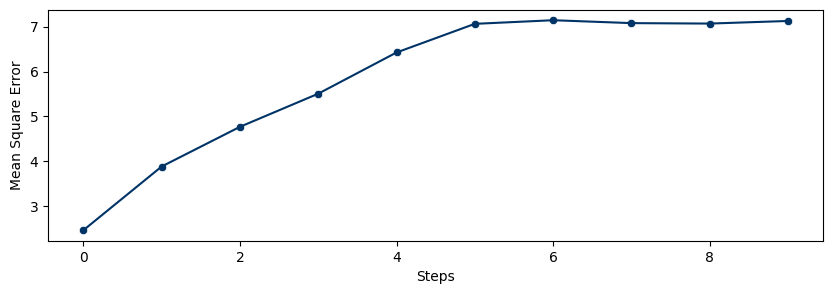

In [11]:
forecast_horizon = pd.DataFrame(forecast_dict).mean(axis=1)

plt.figure(figsize=(10, 3))

sns.scatterplot(x=forecast_horizon.index, y=forecast_horizon)
sns.lineplot(x=forecast_horizon.index, y=forecast_horizon)

plt.xlabel('Steps')
plt.ylabel('Mean Square Error')

plt.show()

Above, we can see the mean squared error (MSE) per step, which shows that the forecast error reaches its maximum after approximately five steps.

We now arrive at a crucial point: ARIMA models produce two types of residuals — those computed on the **training set** and those computed on the **observational (recursive forecast)** data. Our ultimate goal is to forecast the observational residuals, as these reflect real-time forecast errors. However, because they evolve over time, they are not stable enough to be used directly for model training.

Given this, a viable strategy is to train the ARIMA model **in parallel** with a **tree-based model**, and then combine the outputs of both models to generate the final forecast.

# Conclusion

In conclusion, the ARIMA model improves forecast accuracy only up to five steps ahead. Given the residual duality inherent to ARIMA models, our final prediction strategy will combine the ARIMA forecasts with those generated by a tree-based model.